<a href="https://colab.research.google.com/github/marianayarce1224/lab_biosenales/blob/main/PRACTICA3/P3_Parte1_Python_G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="left"><img alt="udeA logo" height="150px" src="https://www.udea.edu.co/wps/wcm/connect/udea/99fc43e7-7a64-45bd-97fc-96639b70813d/logosimbolo-vertical.png?MOD=AJPERES&CVID=ljeLvHr"></p>

<h1><b>Práctica 3 - Parte 1: Análisis estadístico de señales ECG
</b></h1>
<h4><b>Bioseñales y sistemas<br>Universidad de Antioquia, Facultad de Ingeniería - Bioingeniería<br>2024-2</b></h4><br>

<h4><b>Grupo:</b> 3</h4>
<h4><b>Integrantes:</b> Mariana Álvarez Yarce - Ana María Seguro Acevedo</h4>

#<b>Procedimiento</b>

<h4>Realice los enunciados en un Notebook o un script entregable.</h4>

<h4>Implemente una función que permita calcular el valor cuadrático medio (RMS) de una señal. El valor RMS se define en forma discreta con N número de muestras, como:</h4>

<center><h4>$x_{\text{RMS}} = \left[ \frac{1}{N} \sum_{i=1}^{N} x(i)^2 \right]^{\frac{1}{2}}$</center></h4>

In [71]:
import numpy as np

def rms(x):
  n = 0
  for i in range(len(x) - 1):
    n = n + x[i]**2
  x_rms = np.sqrt(1/len(x) * n)
  return x_rms

##<b>Análisis estadístico de ECG</b>

<h4><b>1. </b>A partir de la información suministrada en el archivo .mat, determine el tiempo de duración de las señales, cree un vector de tiempo.</h4>

Se empieza por cargar manualmente desde el dispositivo personal al entorno de Colab el archivo <i>signals.mat</i>, por medio de funciones de la librería <i>Scipy.io</i>. Posteriormente, se construye un dataframe con los registros numéricos y las etiquetas de identificación de cada señal, con el fin de facilitar el manejo de las señales.

Finalmente, se determinó la duración de las señales mediante el cociente del número de muestras y la frecuencia de muestreo de 1024<i>Hz</i>. Para crear el vector de tiempo se utilizó un rango desde 0 hasta el promedio de la duración de todas las señales.

In [72]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

data = loadmat('signals.mat', simplify_cells=True) # se debe cargar manualmente el archivo en Colab en la carpeta llamada 'content'
data_dict = {key: value for key, value in data.items() if not key.startswith('__')}
frequency = data_dict['Fs']
data_dict.pop('Fs')

dfs = [pd.DataFrame(data={key:value}) for key, value in data_dict.items()]
signals_df = pd.concat(dfs, axis=1).fillna(0)

duration = [len(signals_df[signal])/frequency for signal in signals_df.columns]
print(f'Duración promedio de las señales: {np.mean(duration)}')
t = np.linspace(0, round(np.mean(duration))+1, num=signals_df.shape[0])
print(f'\nVector de tiempo: {t}')

Duración promedio de las señales: 30.0009765625

Vector de tiempo: [0.00000000e+00 1.00911458e-03 2.01822917e-03 ... 3.09979818e+01
 3.09989909e+01 3.10000000e+01]


<h4><b>2. </b>Grafique la señal sin filtrar y filtrada, compárelas. Comente lo que observa, y describa cómo debe ser el comportamiento del filtro que se utilizó. Recuerde las frecuencias de interés de la señal ECG.</h4>

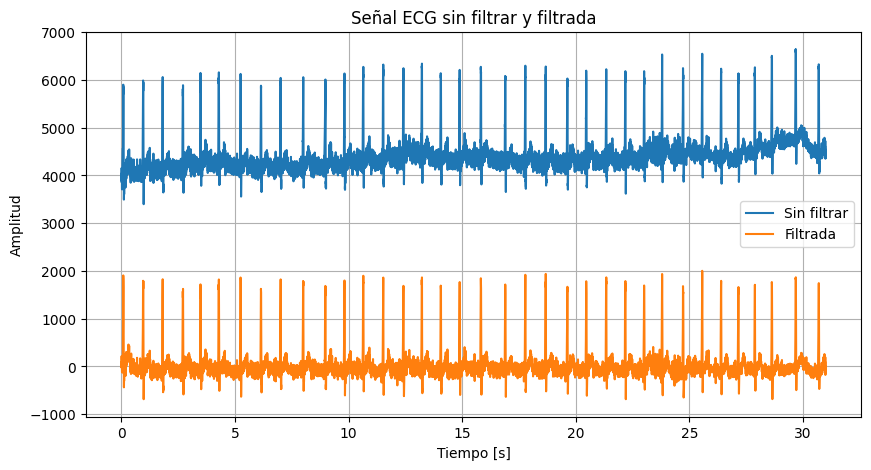

In [73]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

axs.plot(t[:-1], signals_df.loc[signals_df['ECG_asRecording'] != 0]['ECG_asRecording'])
axs.plot(t[:-1], signals_df.loc[signals_df['ECG_filtered'] != 0]['ECG_filtered'])
axs.set_title('Señal ECG sin filtrar y filtrada')
plt.legend(['Sin filtrar', 'Filtrada'])
axs.set_xlabel('Tiempo [s]')
axs.set_ylabel('Amplitud')
axs.grid()
plt.show()

Se observa una disminución de la amplitud en los puntos máximos, así como un ajuste del desfase de la señal sin filtrado que se hallaba centrada entre 3000 y 4000, aproximadamente.  La gráfica de la señal filtrada tiene una tendencia más lineal entre los picos, lo cual puede deberse a la eliminación del ruido de la línea de base (<i>Baseline wander</i>).

In [74]:
ecg_signal = signals_df.loc[signals_df['ECG_asRecording'] != 0].iloc[:, :2]
unfilt_amplitude = ecg_signal['ECG_asRecording'].max() - ecg_signal['ECG_asRecording'].min()
filt_amplitude = ecg_signal['ECG_filtered'].max() - ecg_signal['ECG_filtered'].min()
print(f'Diferencia máxima amplitud (sin filtrar): {unfilt_amplitude}')
print(f'Diferencia máxima amplitud (señal filtrada): {filt_amplitude}')

Diferencia máxima amplitud (sin filtrar): 3245.036865234375
Diferencia máxima amplitud (señal filtrada): 2689.0235325654057


Al calcular las diferencias entre los máximos y mínimos de ambas señales, se evidencia una disminución sutil del rango de amplitud de la señal filtrada con respecto a la no filtrada, con valores de 2689 y 3245, respectivamente.

En base a lo anterior, se puede teorizar que el filtro utilizado tiene un comportamiento basado en varias funciones para acondicionar y limpiar la señal, como la eliminación del ruido de frecuencias altas, el ajuste del desfase en el desplazamiento de la señal, y la conservación de la información más relevante de la señal con los picos característicos, como el complejo QRS. El filtro principal utilizado probablemente sea el pasabandas, configurado para considerar las frecuencias características del ECG que se producen entre 0.05 y 100 Hz <b>[1]</b>, y combinado con otros tipos de filtros para la eliminación de artefactos de ruido y la deriva de la línea base.


<h4><b>3. </b>Tome la señal tal cual se registró. De dicha señal, seleccione un ciclo cardiaco, grafique. Calcule el promedio, el valor RMS, la varianza y la desviación estándar del ciclo. Analice los resultados.</h4>

A partir de la gráfica de toda la señal de <i>ECG_asRecording</i>, se determinó un rango de tiempo aproximado donde empieza el primer ciclo cardíaco y justo antes de que se presente la onda QRS del siguiente ciclo. Este rango se tomó desde el inicio de la señal (0 segundos) hasta aproximadamente 0.8 segundos, de acuerdo a un valor teórico <b>[2]</b> de duración de un ciclo cardíaco normal. Se estableció que el primer ciclo se completó en 802 muestras de la señal.

Tiempo máximo de duración del ciclo: 0.8093098958333335 segundos


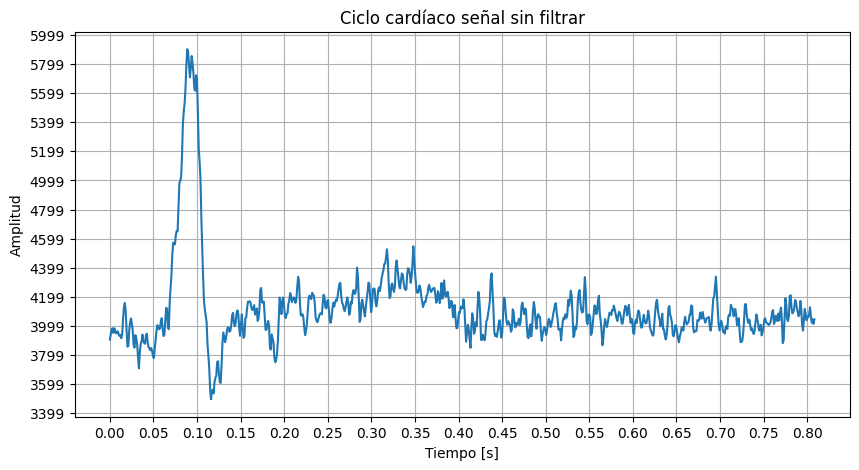

In [75]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

unfilt_signal = signals_df.loc[signals_df['ECG_asRecording'] != 0]['ECG_asRecording'].to_numpy()
axs.set_xticks(np.arange(0, 0.9, 0.05))
axs.set_yticks(np.arange(min(unfilt_signal), max(unfilt_signal), 200))
axs.plot(t[:802], unfilt_signal[:802])
axs.set_xlabel('Tiempo [s]')
axs.set_ylabel('Amplitud')
axs.set_title('Ciclo cardíaco señal sin filtrar')
axs.grid()
print(f'Tiempo máximo de duración del ciclo: {t[802]} segundos')
plt.show()

Obteniendo el índice del tiempo máximo de duración del ciclo tomado anteriormente, se realizó la selección de los valores de la señal de ECG de un ciclo para calcular los siguientes valores:

In [76]:
mean_unfilt = np.mean(unfilt_signal[:802])
rms_unfilt = rms(unfilt_signal[:802])
var_unfilt = np.var(unfilt_signal[:802])
std_unfilt = np.std(unfilt_signal[:802])

print(f'Promedio señal sin filtrar: {mean_unfilt: .2f}')
print(f'Valor RMS señal sin filtrar: {rms_unfilt: .2f}')
print(f'Varianza señal sin filtrar: {var_unfilt: .2f}')
print(f'Desviación estándar señal sin filtrar: {std_unfilt: .2f}')

Promedio señal sin filtrar:  4119.04
Valor RMS señal sin filtrar:  4127.27
Varianza señal sin filtrar:  88315.81
Desviación estándar señal sin filtrar:  297.18


Según la literatura, el rango de voltaje en el se puede presentar la señal de ECG con presencia de ruido y deriva de la línea base (<i>baseline wander</i>) está entre 0.1 mV y 4 mV <b>[3]</b>. Teniendo en cuenta que se le aplicó una amplificación considerable a la señal y que está desfasada en la línea de base, los valores del promedio y RMS son consistentes con el voltaje crítico encontrado. En cuanto a la varianza, es normal que se presente un valor elevado debido a las diferencias significativas en las amplitudes de la señal. La desviación estándar no resultó ser muy alta considerando que la diferencia máxima de amplitudes en la señal sin filtrar es de 3245.

<h4><b>4. </b>Tome la señal filtrada. Repita el procedimiento anterior con esta señal, compare con los resultados obtenidos en el ítem anterior.</h4>

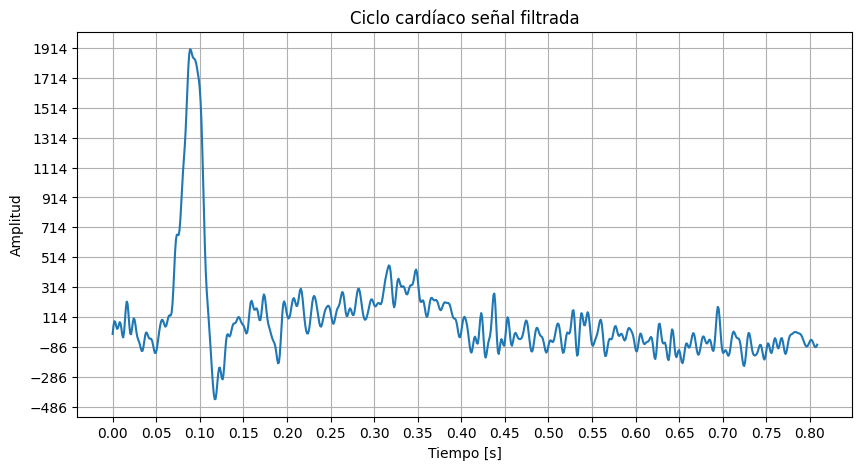

In [77]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

filt_signal = signals_df.loc[signals_df['ECG_filtered'] != 0]['ECG_filtered'].to_numpy()
axs.set_xticks(np.arange(0, 0.9, 0.05))
axs.set_yticks(np.arange(min(filt_signal), max(filt_signal), 200))
axs.plot(t[:802], filt_signal[:802])
axs.set_xlabel('Tiempo [s]')
axs.set_ylabel('Amplitud')
axs.set_title('Ciclo cardíaco señal filtrada')
axs.grid()
plt.show()

In [78]:
mean_filt = np.mean(filt_signal[:802])
rms_filt = rms(filt_signal[:802])
var_filt = np.var(filt_signal[:802])
std_filt = np.std(filt_signal[:802])

print(f'Promedio señal filtrada: {mean_filt: .2f}')
print(f'Valor RMS señal filtrada: {rms_filt: .2f}')
print(f'Varianza señal filtrada: {var_filt: .2f}')
print(f'Desviación estándar señal filtrada: {std_filt: .2f}')

Promedio señal filtrada:  94.78
Valor RMS señal filtrada:  328.45
Varianza señal filtrada:  98904.47
Desviación estándar señal filtrada:  314.49


Se observa una disminución significativa del promedio y la señal RMS con respecto a las obtenidas para la señal sin filtrado, lo que puede deberse a la eliminación de ciertas frecuencias causadas por perturbaciones y la limitación de picos de voltaje producidos por inestabilidades en la medición. Esta disminución también puede deberse a la reubicación y aplanamiento de la línea de base alrededor de cero, por lo que se presentan valores negativos de amplitud (correspondientes a los voltajes de polarización de las células), y esto causa el efecto contrario para la desviación estándar y la varianza debido a una mayor diferencia entre las amplitudes del pico QRS y el resto de los segmentos de menor voltaje.

<h4><b>5. </b>Extraiga 15 ciclos de la señal filtrada, y para cada ciclo calcule el valor promedio y la varianza, grafique cada ciclo, y analice (gráfica y estadísticamente). ¿Se puede considerar que la señal es estacionaria?</h4>

Para hacer la selección de los 15 ciclos, se optó por identificar las posiciones de la señal donde se producen los picos del complejo QRS y dividir cada ciclo en función de estos picos. Inicialmente, se seleccionaron las posiciones de los picos máximos de cada ciclo en 38 intervalos. Este número de intervalos equivale al cociente entre el total de muestras de la señal y 802, que es el número de muestras que se definieron para el primer ciclo y se generalizó para toda la señal.

Para evitar seleccionar picos que no representen el complejo QRS debido a la generalización de las 802 muestras del primer ciclo, se estableció un umbral mínimo de amplitud de 1500. Este umbral se basa en el valor observado en la gráfica, por encima del cual se detectan los picos del complejo QRS.

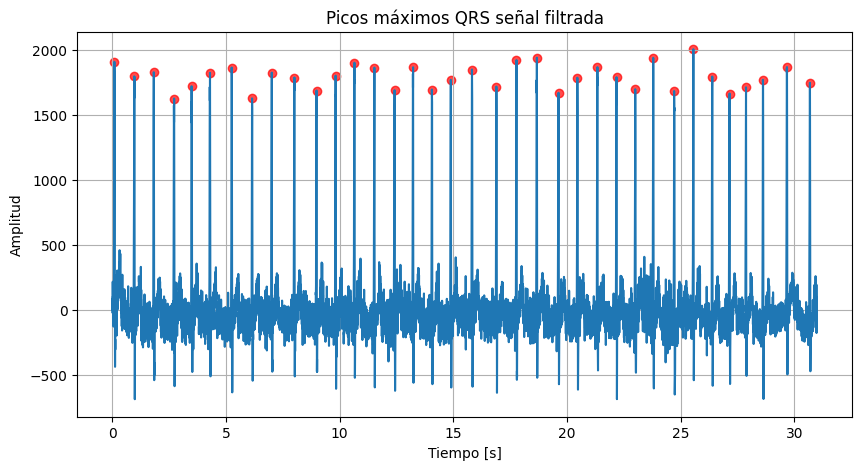

In [79]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

peaks_QRS = []
for i in range(38):
  peaks_QRS.append(max(filt_signal[i*802:(i+1)*802]))
peaks_QRS = np.array(peaks_QRS)
peaks_index = [np.where(filt_signal == peak)[0][0] for peak in peaks_QRS if peak >= 1500]

axs.plot(t[:-1], filt_signal)
axs.scatter(t[peaks_index], filt_signal[peaks_index], color='r', marker='o', alpha=0.7)
axs.set_xlabel('Tiempo [s]')
axs.set_ylabel('Amplitud')
axs.set_title('Picos máximos QRS señal filtrada')
axs.grid()
plt.show()

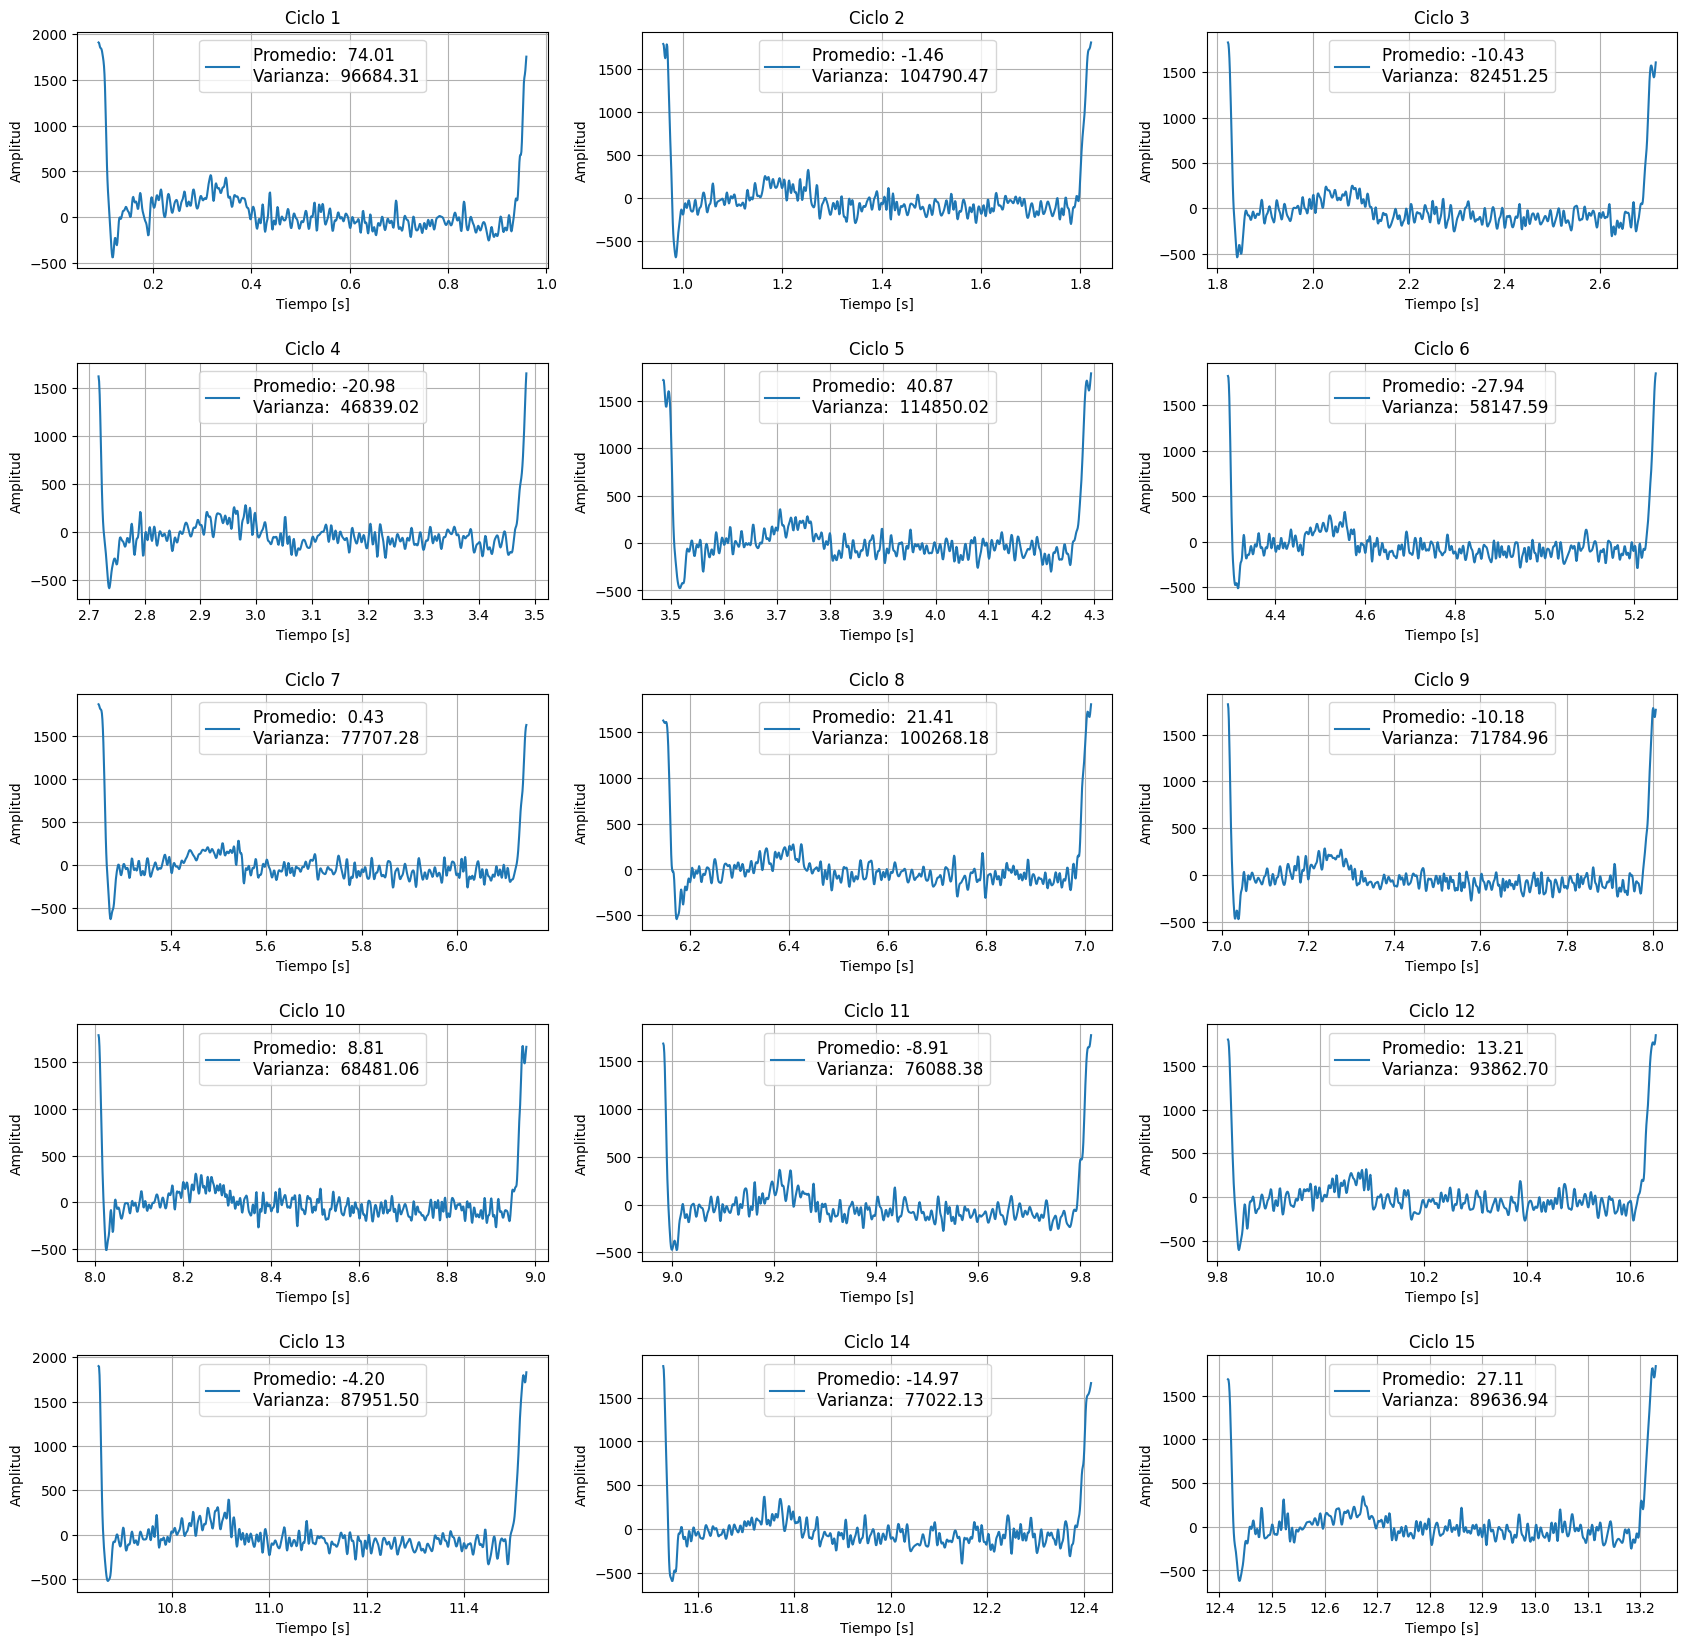

In [80]:
fig, axs = plt.subplots(5,3, figsize=(20, 20))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

cycles = {f'Ciclo {i+1}':[t[peaks_index[i]:peaks_index[i+1]], filt_signal[peaks_index[i]:peaks_index[i+1]]] for i in range(15)}
axs_positions = np.array([[(i, j) for j in range(3)] for i in range(5)]).reshape(15,2)

mean_dic, var_dic = {}, {}
cycles_samples = []
cont = 0
for cycle in cycles:
  mean_cycle = np.mean(cycles[cycle][1])
  var_cycle = np.var(cycles[cycle][1])
  mean_dic[cycle], var_dic[cycle] = mean_cycle, var_cycle
  axs[axs_positions[cont][0], axs_positions[cont][1]].plot(cycles[cycle][0], cycles[cycle][1], label=f'Promedio: {mean_cycle: .2f}\nVarianza: {var_cycle: .2f}')
  axs[axs_positions[cont][0], axs_positions[cont][1]].set_title(cycle)
  axs[axs_positions[cont][0], axs_positions[cont][1]].set_xlabel('Tiempo [s]')
  axs[axs_positions[cont][0], axs_positions[cont][1]].set_ylabel('Amplitud')
  axs[axs_positions[cont][0], axs_positions[cont][1]].legend(fontsize='large')
  axs[axs_positions[cont][0], axs_positions[cont][1]].grid()
  cont += 1
  cycles_samples.append(len(cycles[cycle][1]))

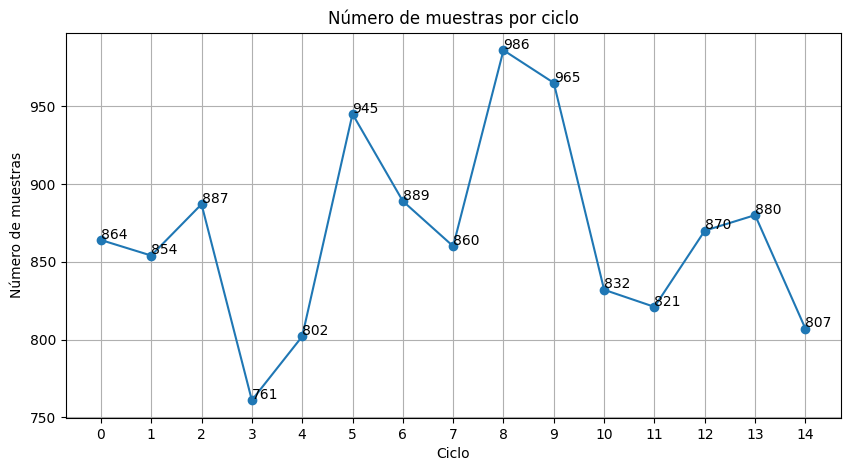

In [81]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

axs.plot(cycles_samples, marker='o')
for i, samples in enumerate(cycles_samples):
  plt.annotate(samples, (i, samples), textcoords='offset points', xytext=(0,1), ha='left')
axs.set_xticks(np.arange(0, 15, 1))
axs.set_xlabel('Ciclo')
axs.set_ylabel('Número de muestras')
axs.set_title('Número de muestras por ciclo')
axs.grid()
plt.show()

Las gráficas evidencian que los ciclos cardíacos seleccionados poseen el segmento T característico de la señal ECG entre cada pico. Asimismo, los picos máximos se encuentran en valores de amplitud entre 1500 y 2000.

En cuanto a los promedios y varianzas, se observan variaciones significativas entre los ciclos seleccionados, lo cual podría ser el resultado de que la selección de las muestras para cada ciclo no fue uniforme y algunos ciclos poseen muchas más muestras que otros intervalos de tiempo elegidos, lo que afecta los cálculos del promedio y varianza, porque consideran el número de muestras como divisor.

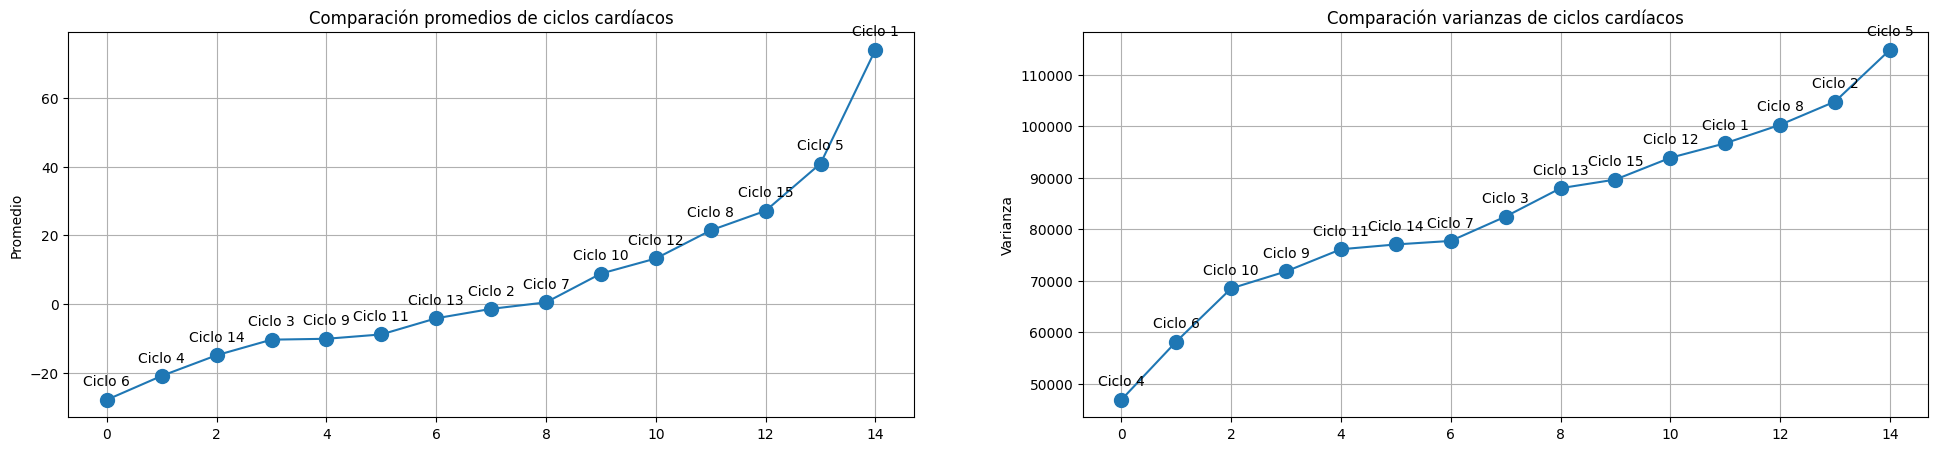

In [82]:
fig, axs = plt.subplots(1,2, figsize=(24, 5))

means, vars = sorted(mean_dic.values()), sorted(var_dic.values())
means_keys = {value: [key for key, val in mean_dic.items() if val == value] for value in means}
vars_keys = {value: [key for key, val in var_dic.items() if val == value] for value in vars}

axs[0].plot(means, marker='o', linestyle='-', markersize=10)
axs[0].set_title('Comparación promedios de ciclos cardíacos')
axs[0].set_ylabel('Promedio')
axs[0].grid()
for i, label in enumerate(means_keys.values()):
  axs[0].annotate(label[0], (i, means[i]), textcoords='offset points', xytext=(0,10), ha='center')

axs[1].plot(vars, marker='o', linestyle='-', markersize=10)
axs[1].set_title('Comparación varianzas de ciclos cardíacos')
axs[1].set_ylabel('Varianza')
axs[1].grid()
for i, label in enumerate(vars_keys.values()):
  axs[1].annotate(label[0], (i, vars[i]), textcoords='offset points', xytext=(0,10), ha='center')

Se observa que tanto el promedio como la varianza tienen un comportamiento no constante para los ciclos seleccionados, lo que implica que no se presenta una estacionariedad en la señal en el tiempo. La estacionariedad también puede descartarse porque los ciclos cardíacos presentan naturalmente variaciones de amplitud significativas, como por ejemplo entre el complejo QRS y el segmento T, lo que afecta los cálculos de varianza y promedio. Si se segmentara la señal de ECG por fases del latido y se compararan aisladamente para cada ciclo, podría suponerse que se puede alcanzar cierta estacionariedad, ya que la señal fisiológica tiene cierto patrón periódico definido.

In [83]:
scaled_vars = [(v - min(vars)) / (max(vars) - min(vars)) for v in vars]
scaled_means = [(v - min(means)) / (max(means) - min(means)) for v in means]
print(f'Varianza de promedios: {np.var(scaled_means): .3f}\nVarianza de varianzas: {np.var(scaled_vars): .3f}')

Varianza de promedios:  0.063
Varianza de varianzas:  0.065


Después de aplicar una normalización Min-Max, las diferencias entre los promedios y las varianzas calculadas para cada ciclo fueron relativamente pequeñas, con una varianza del 6% en ambos casos. Dado que la normalización ajustó los datos a un rango de 0 a 1, estos resultados son consistentes. Sin embargo, es necesario realizar pruebas estadísticas más robustas para obtener conclusiones definitivas sobre la estacionariedad de la señal.

<h4><b>6. </b>Realice dos veces comparaciones entre dos ciclos cualquiera utilizando una prueba t. Determine estadísticamente si existe diferencia estadística entre los ciclos, Compruebe los supuestos necesarios para realizar una prueba t, esto es: Normalidad de la variable, independencia (se asume que los grupos son independientes), y homocedasticidad (use una prueba de Levene), finalmente realice la Prueba t para determinar si existen diferencias entre los ciclos. Qué indica este análisis respecto de la estacionariedad, explique. De no cumplirse los requisitos, realice entonces un análisis no paramétrico (prueba U de Mann-Whitney).</h4>

Para la realización de las pruebas T y la verificación de supuestos, se seleccionaron dos pares de ciclos con un número de muestras similar, como el par del Ciclo 3 (887 muestras) y el Ciclo 7 (889 muestras), y el par del Ciclo 5 (802 muestras) y el Ciclo 15 (807 muestras), para evitar incompatibilidades por números de muestras muy diferentes.

In [84]:
cycle_1 = cycles['Ciclo 3'][1]
cycle_2 = cycles['Ciclo 7'][1]
cycle_3 = cycles['Ciclo 5'][1]
cycle_4 = cycles['Ciclo 15'][1]

<b>Comprobación normalidad (Prueba de Kolmogorov-Smirnov)

In [85]:
from scipy import stats

data = {'Ciclo 3':cycle_1, 'Ciclo 7':cycle_2, 'Ciclo 5':cycle_3, 'Ciclo 15':cycle_4}
print('Prueba de normalidad (valor de significancia: 5%)\n')
alpha = 0.05

for cycle, value in data.items():
  result = stats.kstest(value, 'norm')
  print(f"{cycle}\nValor p:", result.pvalue)
  if result.pvalue < alpha:
      print("Se rechaza la hipótesis nula: Los datos no siguen una distribución normal\n")
  else:
      print("No se rechaza la hipótesis nula: Los datos siguen una distribución normal\n")

Prueba de normalidad (valor de significancia: 5%)

Ciclo 3
Valor p: 0.0
Se rechaza la hipótesis nula: Los datos no siguen una distribución normal

Ciclo 7
Valor p: 0.0
Se rechaza la hipótesis nula: Los datos no siguen una distribución normal

Ciclo 5
Valor p: 1.9931890418145227e-263
Se rechaza la hipótesis nula: Los datos no siguen una distribución normal

Ciclo 15
Valor p: 4.1739325700830397e-265
Se rechaza la hipótesis nula: Los datos no siguen una distribución normal



<b>Comprobación Homocedasticidad (Prueba de Levene)</b>

In [86]:
print('Prueba de homocedasticidad (valor de significancia: 5%)\n')
result_1 = stats.levene(cycle_1, cycle_2)
print(f'Ciclo 3 y Ciclo 7\nValor p:', result_1.pvalue)
if result_1.pvalue <= alpha:
  print('Se rechaza la hipótesis nula: Las varianzas son significativamente diferentes (heteroscedasticidad)\n')
else:
  print('No se rechaza la hipótesis nula: Las varianzas son iguales\n')

result_2 = stats.levene(cycle_3, cycle_4)
print(f'Ciclo 5 y Ciclo 15\nValor p:', result_2.pvalue)
if result_2.pvalue <= alpha:
  print('Se rechaza la hipótesis nula: Las varianzas son significativamente diferentes (heteroscedasticidad)')
else:
  print('No se rechaza la hipótesis nula: Las varianzas son iguales')

Prueba de homocedasticidad (valor de significancia: 5%)

Ciclo 3 y Ciclo 7
Valor p: 0.5639455660012822
No se rechaza la hipótesis nula: Las varianzas son iguales

Ciclo 5 y Ciclo 15
Valor p: 0.19891216458426386
No se rechaza la hipótesis nula: Las varianzas son iguales


Como uno de los supuestos para aplicar la prueba paramétrica de T de Student no se cumplió (ninguno de los ciclos tienen una distribución normal), se procede a aplicar la prueba no paramétrica U de Mann-Whitney para comparar las distribuciones de los ciclos.

In [87]:
print('Prueba U de Mann-Whitney (valor de significancia: 5%)\n')
result_1 = stats.mannwhitneyu(cycle_1, cycle_2)
print(f'Ciclo 3 y Ciclo 7\nValor p:', result_1.pvalue)
if result_1.pvalue <= alpha:
  print('Se rechaza la hipótesis nula: Hay diferencia significativa entre los dos ciclos\n')
else:
  print('No se rechaza la hipótesis nula: No hay diferencia significativa entre los dos ciclos\n')

result_2 = stats.mannwhitneyu(cycle_3, cycle_4)
print(f'Ciclo 5 y Ciclo 15\nValor p:', result_2.pvalue)
if result_2.pvalue <= alpha:
  print('Se rechaza la hipótesis nula: Hay diferencia significativa entre los dos ciclos')
else:
  print('No se rechaza la hipótesis nula: No hay diferencia significativa entre los dos ciclos')

Prueba U de Mann-Whitney (valor de significancia: 5%)

Ciclo 3 y Ciclo 7
Valor p: 0.0025394969126837233
Se rechaza la hipótesis nula: Hay diferencia significativa entre los dos ciclos

Ciclo 5 y Ciclo 15
Valor p: 0.606892790763902
No se rechaza la hipótesis nula: No hay diferencia significativa entre los dos ciclos


A partir de los resultados de la prueba U de Mann-Whitney, es posible concluir que existen ciclos cardíacos en la señal que coinciden significativamente entre sí, pero se presentan otros con ligeras diferencias en amplitud y duración de las fases del latido que implican que la señal no tiene una periodicidad estricta. Puede suponerse entonces que la señal no tendrá estacionariedad en su totalidad por la presencia de ciclos que difieren de los demás.

<h4><b>7. </b>Compruebe los resultados anteriores aplicando una prueba de Dickey-Fuller a la señal (Estacionariedad).</h4>

In [88]:
from statsmodels.tsa.stattools import adfuller

print('Prueba U de Dickey-Fuller (valor de significancia: 5%)\n')
result = adfuller(filt_signal)
print(f'Valor p:', result[1])
if result[1] <= alpha:
  print('Se rechaza la hipótesis nula: La señal en el tiempo es estacionaria')
else:
  print('No se rechaza la hipótesis nula: La señal en el tiempo no es estacionaria')

Prueba U de Dickey-Fuller (valor de significancia: 5%)

Valor p: 0.8581469379838581
No se rechaza la hipótesis nula: La señal en el tiempo no es estacionaria


Como era de esperarse por el análisis de las estadísticas de los ciclos, la prueba de Dickey-Fuller determinó que la señal filtrada de ECG no presenta estacionariedad o tendencia constante en el tiempo. Como se tiene el registro de una señal fisiológica, es posible que durante la medición de la misma hayan influido diversos artefactos de ruido y demás irregularidades que afectaron la representación discreta de la señal de ECG.

#<b>Referencias</b>

<b>[1]:</b> Vidal Silva, & Gatica Rojas. (2010). Diseño e implementación de un sistema electrocardiográfico digital. <i>Rev. Fac. Ing. Univ. Antioquia, 55</i>, 99-107. http://www.scielo.org.co/pdf/rfiua/n55/n55a10.pdf

<b>[2]:</b> Lumen Learning. Cardiac Cycle In <i>Module 3: The Cardiovascular System: The Heart - Anatomy and Physiology II</i>. Lumen Learning. https://courses.lumenlearning.com/suny-ap2/chapter/cardiac-cycle/

<b>[3]:</b> Kumar, P. R., & Kumar Patro, K. (2015). De-noising of ECG raw signal by cascaded window based digital filters configuration [En línea]. En <i>2015 IEEE Power, Communication and Information Technology Conference (PCITC)</i>. Siksha 'O' Anusandhan University. https://doi.org/10.1109/PCITC.2015.7438145